In [1]:
from sqlalchemy import create_engine
from scipy import stats
import statistics as s
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mp
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
IBGEFILE_UNITS = pd.read_csv("data\IBGEFILE.UNITS.csv")

In [3]:
BGEIDSC_EF2EFFP = pd.read_csv("data\BGEIDSC.EF2EFFP.csv")

In [4]:
BGETCHDATA_PTCHTRANH = pd.read_csv("data\BGETCHDATA.PTCHTRANH.csv")

In [5]:
Extranet2_ExactFuelEvents = pd.read_csv("data\Extranet2.ExactFuelEvents.csv")

In [6]:
Extranet2_ExactFuelTankLevels = pd.read_csv("data\Extranet2.ExactFuelTankLevels.csv")

In [7]:
df_vehicle = IBGEFILE_UNITS

In [8]:
df_levels = Extranet2_ExactFuelTankLevels[['TankId', 'TankLevelPercent', 'TankLevelGallons', 'ExactFuelEventId']]

In [9]:
df_events = Extranet2_ExactFuelEvents[['Id', 'EventTimeStamp', 'EquipmentID','DriverID', 'Latitude', 'Longitude','Speed',
                          'Heading', 'Odometer', 'IgnitionStatus','EFReportReason']]

In [10]:
df_optimization = BGEIDSC_EF2EFFP[['TRUCK', 'TANKCAP']]

In [11]:
df_transaction = BGETCHDATA_PTCHTRANH[['TRNID', 'TRNDAT', 'TRNTIM', 'TRNTS#','TRNDRI', 'TRNUNT', 'TRNPI1', 'TRNPQ1']]

In [12]:
df_transaction = df_transaction[~df_transaction['TRNPI1'].isin(['SCLE', 'CADV', 'DEFD', 'ADD ', 'OIL ', 'UREA', 'DEFC'])] 

## Cast keys to common data type 

In [13]:
df_transaction['TRNUNT'] = df_transaction['TRNUNT'].astype(str);
df_optimization['TRUCK'] = df_optimization['TRUCK'].astype(str);
df_events['Id'] = df_events['Id'].astype(str);
df_levels['ExactFuelEventId'] = df_levels['ExactFuelEventId'].astype(str);
df_events['EquipmentID'] = df_events['EquipmentID'].astype(str);

## Clean column values


In [14]:
df_transaction['TRNUNT'] = df_transaction['TRNUNT'].apply(lambda x: x.strip()).replace('', np.nan);
df_optimization['TRUCK'] = df_optimization['TRUCK'].apply(lambda x: x.strip()).replace('', np.nan);
df_events['Id'] = df_events['Id'].apply(lambda x: x.strip()).replace('', np.nan);
df_levels['ExactFuelEventId'] = df_levels['ExactFuelEventId'].apply(lambda x: x.strip()).replace('', np.nan);
df_events['EquipmentID'] = df_events['EquipmentID'].apply(lambda x: x.strip()).replace('', np.nan);

## Merge Dfs together

In [72]:
#A = pd.merge(df_transaction, df_vehicle, how='inner', left_on='TRNUNT', right_on = 'UNUNIT')
#A.head(5)

In [73]:
#B = pd.merge(A, df_optimization, how = 'inner', left_on = 'UNUNIT', right_on = 'TRUCK')
#B.head(5)

In [74]:
#C = pd.merge(df_events_30, df_event_level, how='inner', left_on='Id', right_on = 'ExactFuelEventId')
#C.head(5)

In [72]:
df_event_level = pd.merge(df_events, df_levels, how='inner', left_on='Id', right_on = 'ExactFuelEventId')

In [77]:
##Remove drivers not likely to be thieves 
df_event_level =  df_event_level[~df_event_level['DriverID'].isin(['SMID', 'BEVL', 'RICS', 'NEWR ', 'MARC ', 'LOVH', 'nan', '36728'])] 

#Clean DriverID column to prepare for Harmonic Mean calculation 
df_event_level['DriverID'] = df_event_level['DriverID'].astype(str); 
df_event_level['DriverID'] = df_event_level['DriverID'].apply(lambda x: x.strip()).replace('', np.nan);

## Calculate Harmonic Mean Per DriverID (Max, Median, Min Frequencies) 

In [84]:
from collections import Counter 
drivers = Counter(df_event_level['DriverID'])
drivers = pd.DataFrame(list(drivers.items()), columns=['DriverID', 'Frequency'])
drivers = drivers.sort_values(by='Frequency', ascending=False)
#drivers.dtypes
drivers_is_1 = drivers.query("Frequency == 1")
drivers_df = drivers[~drivers.index.isin(drivers_is_1.index)]

In [85]:
df_event_level = df_event_level[df_event_level['DriverID'].isin(drivers_df['DriverID'])] 
df_event_level = df_event_level.query("DriverID != ''")

In [96]:
#find count to get 50th percentile value 
drivers.count()

DriverID     911
Frequency    911
dtype: int64

In [123]:
drivers_max = pd.DataFrame(drivers['DriverID'].head(1))
#drivers_max

In [111]:
drivers_median = pd.DataFrame(drivers.loc[455].head(1))
drivers_median.rename(columns={455 : 'DriverID'},inplace=True)
#drivers_median

In [112]:
drivers_min = pd.DataFrame(drivers['DriverID'].tail(1))
#drivers_min

In [147]:
df_event_level_min = df_event_level[df_event_level['DriverID'].isin(drivers_min['DriverID'])] 
df_event_level_min['Id'] = df_event_level_min['Id'].astype(int)

harmonic_mean_min = stats.hmean(df_event_level_min["TankLevelPercent"]) 
#harmonic_mean_min
df_event_level_min['Id'].max()

16061059

In [149]:
df_event_level_median = df_event_level[df_event_level['DriverID'].isin(drivers_median['DriverID'])] 
df_event_level_median['Id'] = df_event_level_median['Id'].astype(int)
#df_event_level_median
harmonic_mean_median = stats.hmean(df_event_level_median["TankLevelPercent"]) 
#harmonic_mean_median
df_event_level_median['Id'].max()

21055426

In [151]:
df_event_level_max = df_event_level[df_event_level['DriverID'].isin(drivers_max['DriverID'])] 
df_event_level_max['Id'] = df_event_level_max['Id'].astype(int)
#df_event_level_max
harmonic_mean_max = stats.hmean(df_event_level_max["TankLevelPercent"]) 
#harmonic_mean_max
df_event_level_max['Id'].max()

21142685

## Plot Sampled DriverIDs and compare their FuelLevelPct trends with respective Harmonic Means

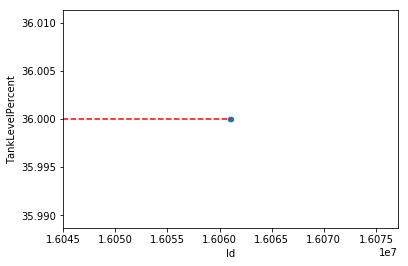

In [137]:
df_event_level_min.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 16061059],[harmonic_mean_min,harmonic_mean_min], 'r--')
plt.xlim(16061059, 16061059)
plt.show()

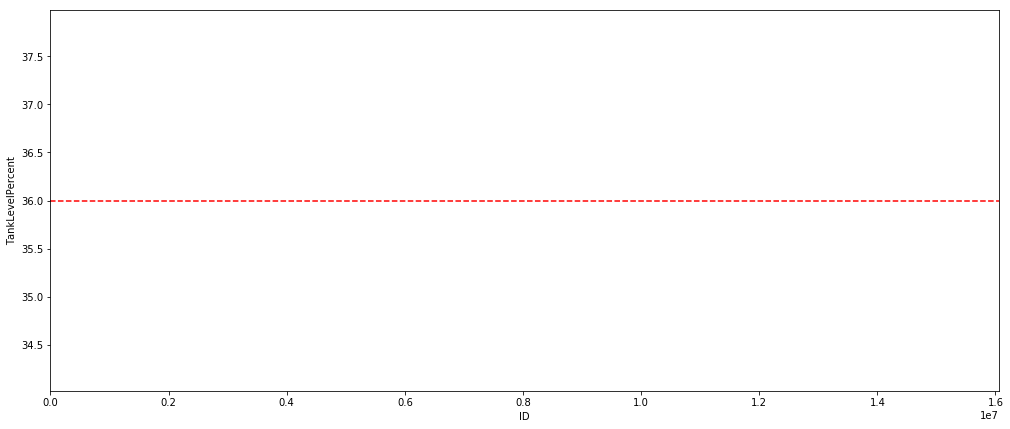

In [150]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_min.Id, df_event_level_min.TankLevelPercent)
_ = plt.plot([0, 16061059],[harmonic_mean_min,harmonic_mean_min], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(0, 16061059)

plt.show();

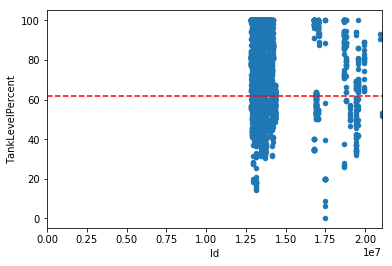

In [154]:
df_event_level_median.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(0, 21055426)
plt.show()

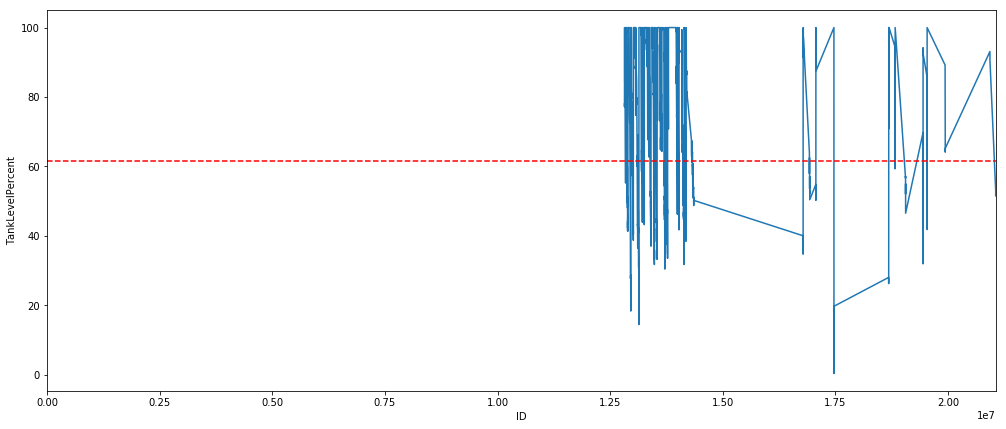

In [155]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_median.Id, df_event_level_median.TankLevelPercent)
_ = plt.plot([0, 21055426],[harmonic_mean_median,harmonic_mean_median], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(0, 21055426)

plt.show();

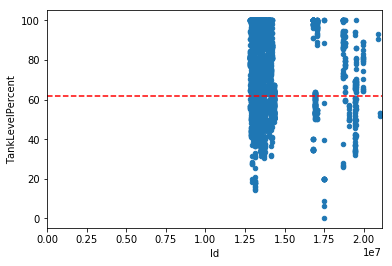

In [156]:
df_event_level_median.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 21142685],[harmonic_mean_median,harmonic_mean_median], 'r--')
plt.xlim(0, 21142685)
plt.show()

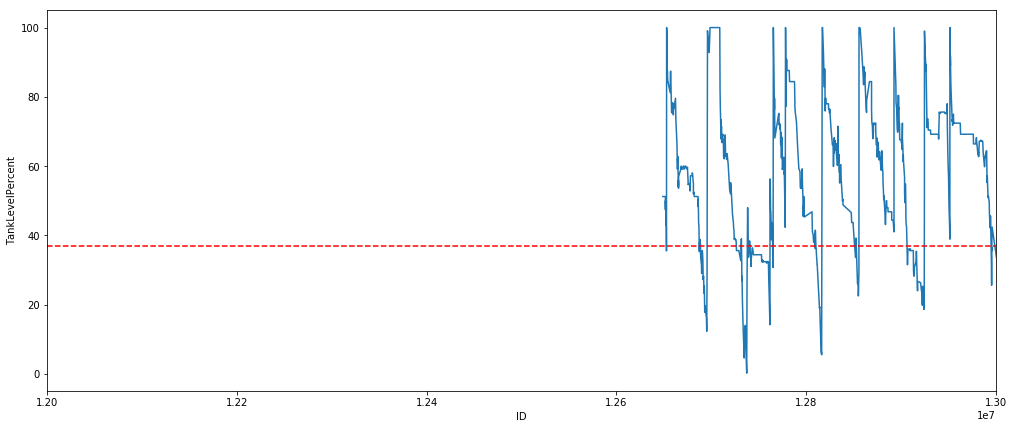

In [160]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_max.Id, df_event_level_max.TankLevelPercent)
_ = plt.plot([12000000, 13000000],[harmonic_mean_max,harmonic_mean_max], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(12000000, 13000000)

plt.show();

In [67]:
df_event_level['Harmonic_Mean'] = stats.hmean(df_event_level.groupby(['DriverID'])['TankLevelGallons']) 

ValueError: setting an array element with a sequence

In [63]:
df_event_level['Harmonic_Mean'] = df_event_level.groupby(['DriverID'])['TankLevelGallons'].apply(s.harmonic_mean)

In [64]:
df_event_level.head(100)

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,Harmonic_Mean
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,0,0.0,39895.5,2,1,1,50.7,101,12649083,NaN
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,0,0.0,360378.8,1,2,1,78.0,156,12649084,NaN
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,67,219.5,377577.4,1,2,1,31.7,63,12649092,NaN
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,0,0.0,513931.8,1,2,1,43.2,108,12649102,NaN
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,3,91.0,498691.0,1,2,1,50.3,125,12649103,NaN
5,12649104,2017-01-01 00:11:08.123,1711,FOSJA,30.51558,-81.63283,3,127.6,342948.0,1,2,1,81.7,163,12649104,NaN
6,12649105,2017-01-01 00:11:48.803,1693,THOCHA,36.18582,-86.26805,0,333.2,340043.7,1,2,1,37.4,74,12649105,NaN
7,12649106,2017-01-01 00:12:26.077,1787,RODMAR,35.16910,-80.88830,53,193.1,224306.6,1,2,1,62.5,125,12649106,NaN
8,12649107,2017-01-01 00:13:02.450,1992,BATK,30.34646,-81.70727,0,0.0,39895.5,1,0,1,52.0,104,12649107,NaN
9,12649108,2017-01-01 00:13:38.137,1711,FOSJA,30.51642,-81.63271,0,96.3,342948.1,2,1,1,79.8,159,12649108,NaN


In [47]:
df_event_level.query("Harmonic_Mean != 'NaN'")

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,Harmonic_Mean


In [38]:
tank = Counter(df_event_level['TankLevelGallons'])
tank

Counter({101.4: 7002,
         156.0: 23947,
         63.4: 3258,
         108.0: 20347,
         125.75: 1494,
         163.4: 6511,
         74.8: 5247,
         125.0: 10301,
         104.0: 10648,
         159.6: 5970,
         77.25: 133,
         101.6: 9453,
         101.52: 223,
         101.99: 149,
         128.0: 17902,
         106.4: 20677,
         73.6: 6096,
         165.6: 21359,
         71.0: 4967,
         130.6: 12458,
         97.06: 754,
         96.6: 10685,
         84.36: 202,
         72.5: 844,
         125.2: 8114,
         123.6: 7657,
         70.4: 6997,
         152.6: 6414,
         114.0: 7722,
         162.6: 6400,
         82.0: 6152,
         225.5: 1680,
         68.62: 308,
         126.5: 3567,
         126.0: 10032,
         122.0: 8688,
         120.0: 47714,
         102.4: 17987,
         117.6: 8070,
         92.0: 11563,
         56.0: 6609,
         239.75: 945,
         235.5: 108,
         68.8: 11369,
         146.0: 7976,
         118

In [23]:
#df_event_level.dtypes

Id                   object
EventTimeStamp       object
EquipmentID          object
DriverID             object
Latitude            float64
Longitude           float64
Speed                 int64
Heading             float64
Odometer            float64
IgnitionStatus        int64
EFReportReason        int64
TankId                int64
TankLevelPercent    float64
TankLevelGallons    float64
ExactFuelEventId     object
Harmonic_Mean       float64
dtype: object

In [389]:
df_event_level.head(2)

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,0,0.0,39895.5,2,1,1,50.7,101.4,12649083
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,0,0.0,360378.8,1,2,1,78.0,156.0,12649084


In [390]:
ABBV_BATK.head(2)

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,0,0.0,39895.5,2,1,1,50.7,101.4,12649083
8,12649107,2017-01-01 00:13:02.450,1992,BATK,30.34646,-81.70727,0,0.0,39895.5,1,0,1,52.0,104.0,12649107


In [406]:
#df_event_level.groupby(['DriverID'])['TankLevelPercent'].apply(harmonic_mean)
ABBV_FURLA = df_event_level.query("['ABBV','FURLA'] in DriverID")
ABBV_FURLA.describe()

,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons
count,6183.000000,6183.000000,6183.000000,6183.000000,6183.000000,6183.000000,6183.000000,6183.0,6183.000000,6183.000000
mean,36.972733,-83.161994,15.704674,167.353259,203999.445463,1.352094,1.060488,1.0,72.380511,144.765612
std,2.590557,4.515127,25.086188,106.703607,17330.257374,0.477662,0.765583,0.0,23.556437,47.118585
min,27.960850,-96.883780,0.000000,0.000000,174238.500000,1.000000,0.000000,1.0,12.600000,25.200000
25%,35.586830,-86.397415,0.000000,76.600000,189738.800000,1.000000,0.000000,1.0,52.700000,105.400000
50%,36.528770,-83.175390,0.000000,169.200000,204373.700000,1.000000,1.000000,1.0,72.300000,144.600000
75%,39.172990,-80.590250,19.000000,258.800000,218470.750000,2.000000,2.000000,1.0,98.400000,196.800000
max,43.375690,-74.060540,78.000000,360.000000,478356.100000,2.000000,2.000000,1.0,100.000000,217.580000


In [407]:
ABBV_FURLA.groupby(['DriverID'])['TankLevelPercent'].apply(s.harmonic_mean)
#s.harmonic_mean([2,3,5])


KeyError: 0

In [301]:
df_event_level

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,Harmonic_Mean
0,12649083,2017-01-01 00:00:32.387,1992,BATK,30.34642,-81.70724,0,0.0,39895.5,2,1,1,50.7,101.40,12649083,NaN
1,12649084,2017-01-01 00:01:24.867,1712,TAYANT,36.93953,-84.09541,0,0.0,360378.8,1,2,1,78.0,156.00,12649084,NaN
2,12649092,2017-01-01 00:04:15.053,1713,RUSR,35.58664,-84.52786,67,219.5,377577.4,1,2,1,31.7,63.40,12649092,NaN
3,12649102,2017-01-01 00:04:10.260,1585,MCAD,35.15430,-90.14263,0,0.0,513931.8,1,2,1,43.2,108.00,12649102,NaN
4,12649103,2017-01-01 00:10:13.187,1564,ULAL,39.90268,-84.19254,3,91.0,498691.0,1,2,1,50.3,125.75,12649103,NaN
5,12649104,2017-01-01 00:11:08.123,1711,FOSJA,30.51558,-81.63283,3,127.6,342948.0,1,2,1,81.7,163.40,12649104,NaN
6,12649105,2017-01-01 00:11:48.803,1693,THOCHA,36.18582,-86.26805,0,333.2,340043.7,1,2,1,37.4,74.80,12649105,NaN
7,12649106,2017-01-01 00:12:26.077,1787,RODMAR,35.16910,-80.88830,53,193.1,224306.6,1,2,1,62.5,125.00,12649106,NaN
8,12649107,2017-01-01 00:13:02.450,1992,BATK,30.34646,-81.70727,0,0.0,39895.5,1,0,1,52.0,104.00,12649107,NaN
9,12649108,2017-01-01 00:13:38.137,1711,FOSJA,30.51642,-81.63271,0,96.3,342948.1,2,1,1,79.8,159.60,12649108,NaN


In [84]:
##Randomly sample drivers to test methodology 
df_event_level.DriverID.unique();
'''BATK, WRIJON, STEDEN, HAMRI, MASSA, SCOJE'''

'BATK, WRIJON, STEDEN, HAMRI, MASSA, SCOJE'

In [163]:
df_event_level.dtypes

Id                    int64
EventTimeStamp       object
EquipmentID           int64
DriverID             object
Latitude            float64
Longitude           float64
Speed                 int64
Heading             float64
Odometer            float64
IgnitionStatus        int64
EFReportReason        int64
TankId                int64
TankLevelPercent    float64
TankLevelGallons    float64
ExactFuelEventId      int64
dtype: object

In [262]:
##Subset dataframe for randomly sampled drivers 
df_event_level_sample_BATK = df_event_level.query("DriverID == 'BATK'").sort_values('EventTimeStamp')
#df_event_level_sample_BATK;

In [263]:
df_event_level_sample_BATK['Distance'] = df_event_level_sample_BATK['Odometer'] - df_event_level_sample_BATK['Odometer'].shift(1)


In [264]:
#Impute values in newly defined Distance column 
df_event_level_sample_BATK['Distance'] = df_event_level_sample_BATK['Distance'].fillna(0)
df_event_level_sample_BATK = df_event_level_sample_BATK.query("Distance != 0")


In [265]:
##Create datetime column 
df_event_level_sample_BATK['Day'] = df_event_level_sample_BATK['EventTimeStamp'].astype(str)

In [266]:
df_event_level_sample_BATK['Day'] = df_event_level_sample_BATK['Day'].str[:10]
df_event_level_sample_BATK['Month'] = df_event_level_sample_BATK['Day'].str[:7]
df_event_level_sample_BATK

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,Distance,Day,Month
11,12649110,2017-01-01 00:15:52.450,1992,BATK,30.34605,-81.70736,0,0.0,39895.6,2,1,1,50.8,101.6,12649110,0.1,2017-01-01,2017-01
33,12649132,2017-01-01 00:41:22.560,1992,BATK,30.36038,-81.76080,63,359.3,39901.1,1,2,1,48.3,96.6,12649132,5.5,2017-01-01,2017-01
64,12649191,2017-01-01 01:02:42.683,1992,BATK,30.61811,-81.64883,0,0.0,39923.4,1,2,1,46.0,92.0,12649191,22.3,2017-01-01,2017-01
78,12649205,2017-01-01 01:17:42.810,1992,BATK,30.62091,-81.52817,48,107.0,39930.8,1,2,1,42.8,85.6,12649205,7.4,2017-01-01,2017-01
93,12649220,2017-01-01 01:30:02.827,1992,BATK,30.67889,-81.45789,0,0.0,39938.3,2,1,1,42.2,84.4,12649220,7.5,2017-01-01,2017-01
99,12649230,2017-01-01 01:34:02.840,1992,BATK,30.67917,-81.45939,0,0.0,39938.4,2,1,1,45.1,90.2,12649230,0.1,2017-01-01,2017-01
133,12649289,2017-01-01 02:00:12.950,1992,BATK,30.68098,-81.45798,2,75.8,39938.6,1,0,1,47.5,95.0,12649289,0.2,2017-01-01,2017-01
140,12649296,2017-01-01 02:09:02.967,1992,BATK,30.67830,-81.45755,7,134.5,39938.8,1,0,1,47.9,95.8,12649296,0.2,2017-01-01,2017-01
141,12649297,2017-01-01 02:12:13.013,1992,BATK,30.67761,-81.45689,0,0.0,39938.9,2,1,1,46.6,93.2,12649297,0.1,2017-01-01,2017-01
158,12649314,2017-01-01 02:32:33.170,1992,BATK,30.63209,-81.46709,46,258.7,39942.4,1,2,1,45.6,91.2,12649314,3.5,2017-01-01,2017-01


In [267]:
df_event_level_sample_BATK['Day'] = pd.to_datetime(df_event_level_sample_BATK['Day'])
df_event_level_sample_BATK['Month'] = pd.to_datetime(df_event_level_sample_BATK['Month'])
df_event_level_sample_BATK.dtypes

Id                           int64
EventTimeStamp              object
EquipmentID                  int64
DriverID                    object
Latitude                   float64
Longitude                  float64
Speed                        int64
Heading                    float64
Odometer                   float64
IgnitionStatus               int64
EFReportReason               int64
TankId                       int64
TankLevelPercent           float64
TankLevelGallons           float64
ExactFuelEventId             int64
Distance                   float64
Day                 datetime64[ns]
Month               datetime64[ns]
dtype: object

In [268]:
df_event_level_sample_BATK

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,Distance,Day,Month
11,12649110,2017-01-01 00:15:52.450,1992,BATK,30.34605,-81.70736,0,0.0,39895.6,2,1,1,50.8,101.6,12649110,0.1,2017-01-01,2017-01-01
33,12649132,2017-01-01 00:41:22.560,1992,BATK,30.36038,-81.76080,63,359.3,39901.1,1,2,1,48.3,96.6,12649132,5.5,2017-01-01,2017-01-01
64,12649191,2017-01-01 01:02:42.683,1992,BATK,30.61811,-81.64883,0,0.0,39923.4,1,2,1,46.0,92.0,12649191,22.3,2017-01-01,2017-01-01
78,12649205,2017-01-01 01:17:42.810,1992,BATK,30.62091,-81.52817,48,107.0,39930.8,1,2,1,42.8,85.6,12649205,7.4,2017-01-01,2017-01-01
93,12649220,2017-01-01 01:30:02.827,1992,BATK,30.67889,-81.45789,0,0.0,39938.3,2,1,1,42.2,84.4,12649220,7.5,2017-01-01,2017-01-01
99,12649230,2017-01-01 01:34:02.840,1992,BATK,30.67917,-81.45939,0,0.0,39938.4,2,1,1,45.1,90.2,12649230,0.1,2017-01-01,2017-01-01
133,12649289,2017-01-01 02:00:12.950,1992,BATK,30.68098,-81.45798,2,75.8,39938.6,1,0,1,47.5,95.0,12649289,0.2,2017-01-01,2017-01-01
140,12649296,2017-01-01 02:09:02.967,1992,BATK,30.67830,-81.45755,7,134.5,39938.8,1,0,1,47.9,95.8,12649296,0.2,2017-01-01,2017-01-01
141,12649297,2017-01-01 02:12:13.013,1992,BATK,30.67761,-81.45689,0,0.0,39938.9,2,1,1,46.6,93.2,12649297,0.1,2017-01-01,2017-01-01
158,12649314,2017-01-01 02:32:33.170,1992,BATK,30.63209,-81.46709,46,258.7,39942.4,1,2,1,45.6,91.2,12649314,3.5,2017-01-01,2017-01-01


In [256]:
df_event_level_sample_BATK = df_event_level_sample_BATK.query("Day == '2017-01-01'")
df_event_level_sample_BATK

,Id,EventTimeStamp,EquipmentID,DriverID,Latitude,Longitude,Speed,Heading,Odometer,IgnitionStatus,EFReportReason,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId,Distance,Day,Month
11,12649110,2017-01-01 00:15:52.450,1992,BATK,30.34605,-81.70736,0,0.0,39895.6,2,1,1,50.8,101.6,12649110,0.1,2017-01-01,2017-01-01
33,12649132,2017-01-01 00:41:22.560,1992,BATK,30.36038,-81.76080,63,359.3,39901.1,1,2,1,48.3,96.6,12649132,5.5,2017-01-01,2017-01-01
64,12649191,2017-01-01 01:02:42.683,1992,BATK,30.61811,-81.64883,0,0.0,39923.4,1,2,1,46.0,92.0,12649191,22.3,2017-01-01,2017-01-01
78,12649205,2017-01-01 01:17:42.810,1992,BATK,30.62091,-81.52817,48,107.0,39930.8,1,2,1,42.8,85.6,12649205,7.4,2017-01-01,2017-01-01
93,12649220,2017-01-01 01:30:02.827,1992,BATK,30.67889,-81.45789,0,0.0,39938.3,2,1,1,42.2,84.4,12649220,7.5,2017-01-01,2017-01-01
99,12649230,2017-01-01 01:34:02.840,1992,BATK,30.67917,-81.45939,0,0.0,39938.4,2,1,1,45.1,90.2,12649230,0.1,2017-01-01,2017-01-01
133,12649289,2017-01-01 02:00:12.950,1992,BATK,30.68098,-81.45798,2,75.8,39938.6,1,0,1,47.5,95.0,12649289,0.2,2017-01-01,2017-01-01
140,12649296,2017-01-01 02:09:02.967,1992,BATK,30.67830,-81.45755,7,134.5,39938.8,1,0,1,47.9,95.8,12649296,0.2,2017-01-01,2017-01-01
141,12649297,2017-01-01 02:12:13.013,1992,BATK,30.67761,-81.45689,0,0.0,39938.9,2,1,1,46.6,93.2,12649297,0.1,2017-01-01,2017-01-01
158,12649314,2017-01-01 02:32:33.170,1992,BATK,30.63209,-81.46709,46,258.7,39942.4,1,2,1,45.6,91.2,12649314,3.5,2017-01-01,2017-01-01


In [269]:
'''g = sns.FacetGrid(df_event_level_sample_BATK, col="Day")
g = (g.map(plt.scatter, 'Id', 'TankLevelPercent'))
g = (g.map(plt.xlim(12600000, 12900000)))
plt.show()'''

'g = sns.FacetGrid(df_event_level_sample_BATK, col="Day")\ng = (g.map(plt.scatter, \'Id\', \'TankLevelPercent\'))\ng = (g.map(plt.xlim(12600000, 12900000)))\nplt.show()'

In [270]:
##Calculate harmonic mean of TankLevelPercent for sampled DriverID
harmonic_mean = stats.hmean(df_event_level_sample_BATK["TankLevelPercent"]) 


In [157]:
#df_event_level_sample_BATK
#df_event_level_sample_BATK.plot.scatter('Id','TankLevelPercent');
#plt.xlim(12600000, 12900000);
#plt.show();
print(harmonic_mean)

46.45947562534631


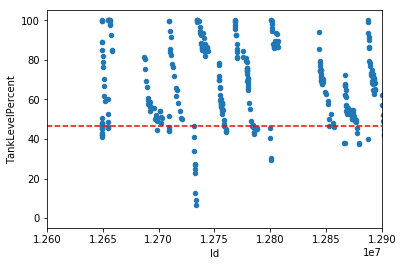

In [281]:
#df_event_level_sample_BATK
df_event_level_sample_BATK.plot.scatter('Id','TankLevelPercent')
plt.plot([0, 12900000],[harmonic_mean,harmonic_mean], 'r--')
plt.xlim(12600000, 12900000)
plt.show()

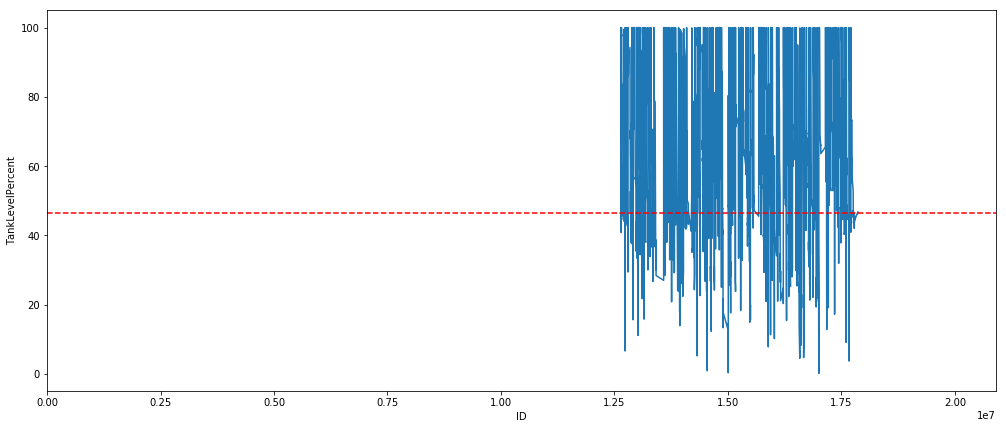

In [289]:
plt.figure(figsize=[17,7])
_ = plt.plot(df_event_level_sample_BATK.Id, df_event_level_sample_BATK.TankLevelPercent)
_ = plt.plot([0, 20900000],[harmonic_mean,harmonic_mean], 'r--')
_ = plt.xlabel('ID')
_ = plt.ylabel('TankLevelPercent')
_ = plt.xlim(0, 20900000)

plt.show();

In [274]:
#Fuel_Transactions.query("TankLevelPercent > 100.0")
#Fuel_Transactions['EventTimeStamp'].max();

In [258]:
C['DriverID'].value_counts().head(1)
#A = pd.DataFrame(C.['Id_y'].value_counts().max())
#A.sort_values(by=['Id_y'], ascending=False)


DYET    33866
Name: DriverID, dtype: int64

In [66]:
##us = gpd.read_file('data\USA_adm1.shp')

In [67]:
##fig, ax = plt.subplots(figsize = (300, 300), subplot_kw = {'aspect': 'equal'})
##us.plot(ax=ax, color="grey")u